# Chapter 2: Solving Linear System
MTH 264 Numerical Methods

Kittapat Ratanaphupha

## Library-based method: `np.linalg.solve`
For the simplest way to solve the linear equation, as we know the form that looks like this equation:
$$ A\mathbf{x} = \mathbf{b},$$
where $A$ is a square matrix in dimension of $n \times n$, $\mathbf{x}$ and $\mathbf{b}$ are the vectors which have the same dimension as $n$ dimension, but $\mathbf{b}$ is determined.

What we would like to solve is the vector $\mathbf{x}$. In Python built-in, there is a function called `np.linalg.solve` as we will implement below.

This function requires two arguments for running it. Those are $A$ and $\mathbf{b}$. The result that will be returned in the function is $\mathbf{x}$.

In [1]:
import numpy as np
np.linalg.solve([[1,1,1],[1,5,1],[0.1, 10, 1]], [10,20, 30])

array([2.77777778, 2.5       , 4.72222222])

For the example, we examine this linear equation,

$$\begin{pmatrix} 1&1&1 \\ 1&5&1 \\ 0.1&10&1 \end{pmatrix}\mathbf{x} = \begin{pmatrix}10 \\ 20 \\ 30\end{pmatrix}$$

As the introductory course, we can solve it with two approaches analytically: Cramer's method and Gaussian elimination.

Although, as the built-in function in Numpy have, the function is referenced from LAPACK routine `_gesv`. (Ref: [Developer Reference for Intel oneAPI Math Kernel Library](https://software.intel.com/content/www/us/en/develop/documentation/onemkl-developer-reference-c/top/lapack-routines/lapack-linear-equation-routines/lapack-linear-equation-driver-routines/gesv.html)) The function follows the reputed algorithm, LUP decomposition.

### Floating points
For linear equation solving algorithm, the main component of it is the reciprocal of the element in matrix that is stored in `double` datatype.

According to `double` datatype structure (double-precision floating point format), as the definition in IEEE 754-2008, the variable in this datatype always stores 64-bit of data in the memory.

<p align = "center"><img src = "https://i.stack.imgur.com/AyCTR.png"/></p>

The structure can be classified in three categories: the signed bit, the exponent bits (11-bit), and the precision bits (52-bit). If the bits are represented as $b_i$ in i-th bit, certain double-precision floating point will be represented a number as:

$$x = \underbrace{(-1)^{b_0}}_{\text{sign bit}} \underbrace{2^{(-1)^{b_1}\sum_{i = 2}^{11} 2^{11-i} b_i}}_{\text{exponent bits}} \underbrace{\sum_{i = 12}^{63} 2^{-64+i} b_i}_{\text{precision bits}}$$

The largest value in magnitude that `double` can be represented is $2^{1023} \sum_{i=0}^{52} 2^{-i}$ or $\sim 1.797 \times 10^{308}$,

and $2^{-1074}$ or $\sim 5 \times 10^{-324}$ for machine epsilon.

As the code here, we cannot add or subtract any floating points into this to get higher precision/values; you will get overflow error by such attempts.

In [2]:
summand = 0
for i in range(53):
    summand += 2**-i

float(2**-1023 * 2 ** -51), float(2**1023 * summand)

(5e-324, 1.7976931348623157e+308)

Although, if we give the higher precision scheme in the script, we will face a situation that the function with respect to their values will give more error due to an aggravated round-off error.

### LUP decomposition

As `np.linalg.solve` is inspired of, this algorithm bases the certain function to calculate a linear equation system solving by decompose the equation to a form like this,
$$A\mathbf{x} = \mathbf{b} \rightarrow LU\mathbf{x} = P\mathbf{b},$$

where $P$ is permutation matrix, $L$ is lower triangular matrix with diagonal terms, and $U$ is higher triangular matrix with diagonal terms.

This algorithm is inspired by Gaussian elimination. The elimination has two features to calculate the matrix $A$ to $U$, $L$, and $P$: partial pivot and addition/subtraction by row. It can solve recursively such the below function will follow this routine by reducing squared matrix dimension from $n$ to $n-1$ dimensions until it meets 1 dimension. Then, we will resemble the matrix to get full results.

In [3]:
def LUP_decomp(A):
    assert len(A) == len(A[0]), "The matrix must be squared matrix."

    if len(A) == 1:
        L = [[1]]
        U = A
        P = [[1]]
        return L, U, P
    
    # Choose i as largest element index at the first row
    cut_index = 0
    tmp_max = abs(A[0][0])
    for index in range(len(A[0])):
        if abs(A[index][0]) > tmp_max:
            cut_index = index
            tmp_max = A[index][0]
    assert tmp_max > 1e-10, "An element in matrix is too small, beware of overflowing."
    
    # Permutation
    new_A = []
    row = []
    col = []
    denominator = 0
    for i in range(len(A)):
        tmp_row = []
        for j in range(len(A[0])):
            if j == 0:
                if i == cut_index: denominator = A[i][j]
                else: row.append(A[i][j])
            elif i == 0: col.append(A[cut_index][j])
            elif i <= cut_index: tmp_row.append(A[i - 1][j])
            else: tmp_row.append(A[i][j])
        if tmp_row != []: new_A.append(tmp_row)

    for i in range(len(new_A)):
        for j in range(len(new_A)):
            new_A[i][j] = new_A[i][j] - row[i] * col[j] / denominator

    L22, U22, P22 = LUP_decomp(new_A)
    
    L11 = 1
    U11 = denominator

    L12 = [0] * (len(A) - 1)
    U12 = col

    L21 = []
    for i in range(len(row)):
        summand = 0
        for j in range(len(row)):
            summand += P22[i][j] * row[j] / denominator
        L21.append(summand)
    
    U21 = [0] * (len(A) - 1)

    L = []
    U = []
    P = []

    for i in range(len(A)):
        tmp_L = []
        tmp_U = []
        tmp_P = []
        for j in range(len(A)):
            if (i == 0):
                if (j == 0):
                    tmp_L.append(L11)
                    tmp_U.append(U11)
                else:
                    tmp_L.append(L12[j - 1])
                    tmp_U.append(U12[j - 1])
                tmp_P.append(1 if j == cut_index else 0)
            elif (j == 0):
                tmp_L.append(L21[i - 1])
                tmp_U.append(U21[i - 1])
                tmp_P.append(P22[i - 1][j] if j != cut_index else 0)
            else:
                tmp_L.append(L22[i - 1][j - 1])
                tmp_U.append(U22[i - 1][j - 1])
                if (j < cut_index):
                    tmp_P.append(P22[i - 1][j])
                elif (j > cut_index):
                    tmp_P.append(P22[i - 1][j - 1])
                else:
                    tmp_P.append(0)
        L.append(tmp_L)
        U.append(tmp_U)
        P.append(tmp_P)

    return L, U, P

### Solving the equation by LUP decomposition
As we implemented the algorithm, the decomposition can solve the equation easily by two-step of substitution (forward and backward).
First, we encounter with an equation $L\mathbf{y} = P\mathbf{b}$. The solution in this equation can be solved by using forward substitution as the formula below.
$$\mathbf{y}_i = \frac{(P\mathbf{b})_i - \sum_{j = 0}^{i - 1} L_{ij}\mathbf{y}_j}{L_{ii}},$$

and second formula for solving $U\mathbf{x} = \mathbf{y}$ as,

$$\mathbf{x}_i = \frac{\mathbf{x}_i - \sum_{j = i + 1}^n U_{ij}\mathbf{x}_{ij}}{U_{ii}}.$$

In [4]:
def matrix_mul(A, B):
    if type(A[0]) == list:
        len_A0 = len(A[0])
        len_A = len(A)
        assert len(A[0]) == len(B), "Column length of A and row length of B are not equal."
    else:
        len_A0 = len(A)
        len_A = 1
        assert len(A) == len(B), "Column length of A and row length of B are not equal."
    
    x = []

    if type(B[0]) == list: len_B0 = len(B[0])
    else: len_B0 = 1

    for i in range(len_A):
        x_row = []
        for k in range(len_B0):
            summand = 0
            for j in range(len_A0):
                A_mul = A[j] if type(A[0]) != list else A[i][j]
                B_mul = B[j] if type(B[0]) != list else B[j][k]
                summand += A_mul * B_mul
            x_row.append(summand)
        x.append(x_row if type(B[0]) == list else x_row[0])
    return x if (type(x[0]) == list) or (len(x) > 1) else x[0]

def LUP_solver(A, b):
    L, U, P = LUP_decomp(A)
    Pb = matrix_mul(P, b)

    y = []
    for i in range(len(Pb)):
        summand = 0
        for j in range(i):
            summand += L[i][j] * y[j] / L[i][i]
        y.append(Pb[i] / L[i][i] - summand)

    x = []
    for i in range(len(Pb) - 1, -1, -1):
        summand = 0
        for j in range(len(Pb) - 1, i, -1):
            summand += U[i][j] * x[j - i - 1] / U[i][i]
        x = [y[i] / U[i][i] - summand] + x
    return x

For testing a correctness in the algorithm, the same equation as the usage on `np.linalg.solve` above is to verify this function.

In [5]:
LUP_solver([[1,1,1],[1,5,1],[0.1, 10, 1]], [10, 20, 30])

[2.7777777777777803, 2.5, 4.72222222222222]

and it gives the same result as library-based method.

## Jacobi Method

In the case that matrix has no zero terms on diagonal ones and the matrix has only simple numbers, the easier implementation can be applied as iterative methods as we present in this file.

The iterative methods for solving a linear system consists two approaches, Jacobi method and Gauss-Seidel method. By the fixed point iteration, we can apply its benefits to solve the equation by separating $\mathbf{x}$ on both sides of the equation. In Jacobi method, $A$ is decomposed by $D + (L + U)$. The equation can be written by the alternative form of $D\mathbf{x} = \mathbf{b} - (L+U)\mathbf{x}$ where $D$ is diagonal matrix, $L$ is strictly lower triangular matrix, and $U$ is strictly upper triangular matrix.

The fixed point iteration can give an iterative method as,

$$\mathbf{x}_k = D^{-1}(\mathbf{b}-(L+U)\mathbf{x}_{k-1}).$$

In [56]:
import random

def jacobi_method(matrix, row_vector, iteration):
    x = [random.randrange(-10000, 10000)/10000 for i in range(len(row_vector))]
    x1 = [0 for i in range(len(row_vector))]
    for n in range(iteration):
        for i in range(len(x)):
            summand = 0
            for j in range(len(x)):
                if i != j: summand += matrix[i][j] * x[j]
            x1[i] = 1/(matrix[i][i])*(row_vector[i] - summand)
        x = x1
    return x1

The same linear system is tested for correctness in this function. As the same as the before, the results is correct.

In [57]:
jacobi_method([[1,1,1],[1,5,1],[0.1, 10, 1]], [10,20, 30], 100)

[2.7777777777777786, 2.5, 4.722222222222221]

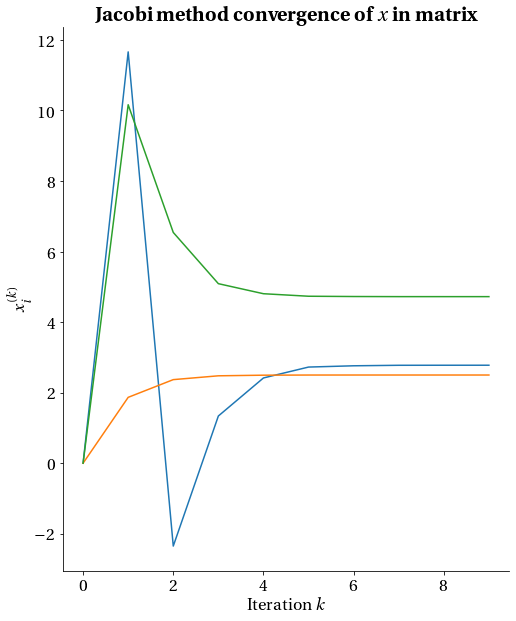

In [68]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('text', usetex=True)
matplotlib.rc('font', size=18)
matplotlib.rc('legend', fontsize=18)
matplotlib.rc('text.latex', preamble=r'\usepackage{fourier}')

plt.rcParams["font.family"] = "serif"

fig, ax = plt.subplots(figsize = (8,10))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

jacobi_result = []
for i in range(10):
    jacobi_result.append(gauss_seidel([[1,1,1],[1,5,1],[0.1, 10, 1]], [10,20, 30], i))
plt.plot(np.array(jacobi_result)[:,0])
plt.plot(np.array(jacobi_result)[:,1])
plt.plot(np.array(jacobi_result)[:,2])
plt.title(r"\textbf{Jacobi method convergence of $x$ in matrix}")
plt.ylabel(r"$x_i^{(k)}$")
plt.xlabel(r"Iteration $k$")
plt.show()

## Gauss-Seidel Method
Also in this method, the method is iterative as Jacobi method, but decomposes $A$ as only $L^* + U$ where $L^* = L+D$ and $U$ is the same $U$ as the Jacobian method. The recursion relation in this method is,
$$L^*\mathbf{x}_{k} = \mathbf{b} - U\mathbf{x}_{k-1}.$$

The equation will solve explicitly by this relation,
$$\mathbf{x}_{k} = \underbrace{L^{*-1}}_{\text{Forward substitution}}(\mathbf{b} - U\mathbf{x}_{k-1})$$

In [32]:
def gauss_seidel(matrix, row_vector, iteration):
    x = [random.randrange(-10000, 10000)/10000 for i in range(len(row_vector))]
    x1 = [0 for i in range(len(row_vector))]
    for n in range(iteration):
        for i in range(len(x)):
            summand_L = 0
            summand_U = 0
            for j in range(len(x)):
                if j < i: summand_L += matrix[i][j] * x1[j]
                if j > i: summand_U += matrix[i][j] * x[j]
            x1[i] = 1/matrix[i][i] * (row_vector[i] - summand_L - summand_U)
        x = x1
    return x1

As we see that, a function can solve the same system in the same result as the previous ones.

In [35]:
gauss_seidel([[1,1,1],[1,5,1],[0.1, 10, 1]], [10,20, 30], 100)

[2.7777777777777786, 2.5, 4.722222222222221]

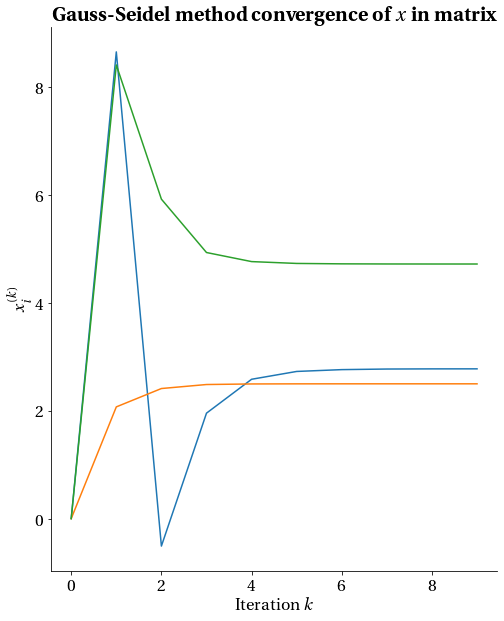

In [70]:
gauss_result = []
for i in range(10):
    gauss_result.append(gauss_seidel([[1,1,1],[1,5,1],[0.1, 10, 1]], [10,20, 30], i))

fig, ax = plt.subplots(figsize = (8,10))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.plot(np.array(gauss_result)[:,0])
plt.plot(np.array(gauss_result)[:,1])
plt.plot(np.array(gauss_result)[:,2])
plt.title(r"\textbf{Gauss-Seidel method convergence of $x$ in matrix}")
plt.ylabel(r"$x_i^{(k)}$")
plt.xlabel(r"Iteration $k$")
plt.show()

## Time-complexity analysis
According to these algorithms, the time complexity in LUP decomposition approach is slower than the lastest methods due to fast convergences. Although, time complexity is arbitrary with the matrix. When the matrix is complex to solve, LUP decomposition will be get faster speed for solving the systems according to its static approach.

In [63]:
%timeit LUP_solver([[1,1,1],[1,5,1],[0.1, 10, 1]], [10,20, 30])
%timeit jacobi_method([[1,1,1],[1,5,1],[0.1, 10, 1]], [10,20, 30], 6)
%timeit gauss_seidel([[1,1,1],[1,5,1],[0.1, 10, 1]], [10,20, 30], 6)

33.5 µs ± 1.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
18.4 µs ± 253 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
20.3 µs ± 184 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## Summary
| Algorithm | Approach | Simple matrix solving time | Complex matrix solving time | Matrix with some zeros in diagonal terms |
|---|---|---|---|---|
| LUP Decomposition | Recursive, Gaussian Elimination | Slowest | Medium | Possible |
| Jacobian Method | Iterative, Fixed-Point Iteration | Fastest | Slow | Impossible |
| Gauss-Seidel Method | Iterative, Fixed-Point Iteration | Fast | Slow | Impossible |